In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

In [2]:
df = pd.read_csv("data/data.csv", names=["ts", "dist", "X", "Y"], skiprows=1)
df.head()

,ts,dist,X,Y
0,2020-06-16_08-53-24-362221,242.32,0.0,0.0
1,2020-06-16_08-53-25-504531,241.55,0.0,0.2
2,2020-06-16_08-53-26-657194,183.66,0.0,0.5
3,2020-06-16_08-53-27-807611,121.49,0.0,0.5
4,2020-06-16_08-53-28-958042,112.80,-1.0,0.5


In [3]:
print(df.shape, df.loc[df["Y"] > 0].shape)

(2656, 4) (2626, 4)


In [4]:
img_root = "data/imgs"

dataset=None

# get only data where ABS_Y > 0
for elem in df.loc[df["Y"] > 0].values:
    img = keras.preprocessing.image.load_img(f"{img_root}/{elem[0]}.jpg")
    if dataset is None:
        dataset = np.array([keras.preprocessing.image.img_to_array(img)])
        labels = np.array([elem[-2:]])
        continue
    dataset = np.vstack((dataset, [keras.preprocessing.image.img_to_array(img)]))
    labels = np.vstack((labels, [elem[-2:]]))


[0.0 0.9]


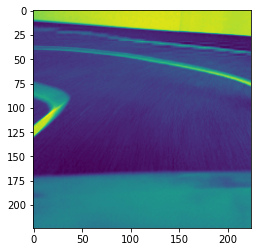

In [5]:
print(labels[-1])
plt.imshow(dataset[-1,:,:,0])

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
                                    dataset.astype(np.float32), 
                                    labels.astype(np.float32),  
                                    test_size=0.1, 
                                    random_state=20200626
                                 )

In [7]:
# class MixerGenerator():
#     def __init__(self, x, y, mix_rate):
#         self.x = x
#         self.y = y
#         self.size = x.shape[0]
#         self.r = mix_rate
        
#     def _mix_two(self):
#         p = np.random.random()
#         i1, i2 = [np.random.randint(0, self.size) for _ in range(2)]
#         if p < self.r:
#             w1 = np.random.random()
#             w2 = 1-w1            
#             x = w1*self.x[i1] + w2*self.x[i2]
#             y = w1*self.y[i1] + w2*self.y[i2]
#         else:
#             x = self.x[i1]
#             y = self.y[i1]
            
#         return x.astype(np.float32), y.astype(np.float32)
    
#     def generate(self, batch_size=32):
#         batch_x, batch_y = None, None
#         for _ in range(batch_size):
#             if batch_x is None:
#                 batch_x, batch_y = self._mix_two()
#                 continue
#             x, y = self._mix_two()
#             batch_x = np.vstack((batch_x, x))
#             batch_y = np.vstack((batch_y, y))
#         return batch_x, batch_y

In [8]:
# mix_gen = MixerGenerator(x_train, y_train, 0.5)
# x, y = mix_gen.generate(batch_size=1)
# print(y)
# plt.imshow(x[:, :, 0])

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

inputs = keras.Input(shape=(None, None, 3))
x = Rescaling(scale=1.0 / 255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)

# Global average pooling to get flat feature vectors
x = layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(.2)(x)
x = layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dropout(.2)(x)
x = layers.Dense(8, activation="relu")(x)
outputs = layers.Dense(2, activation="linear")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
rescaling (Rescaling)        (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    9248  

In [11]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.94)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=opt, loss='mse')

In [12]:
def mapping(x):
    """map [0,1] to [-1,1]"""
    return 2*x-1

def revert_mapping(x):
    return 0.5*(x+1)

y_train[:,1] = mapping(y_train[:, 1])
y_val[:,1] = mapping(y_val[:, 1])

In [13]:
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=400)

Epoch 1/400
74/74 [==============================] - 2s 20ms/step - loss: 0.1941 - val_loss: 0.1586
Epoch 2/400
74/74 [==============================] - 1s 16ms/step - loss: 0.1704 - val_loss: 0.1546
Epoch 3/400
74/74 [==============================] - 1s 16ms/step - loss: 0.1664 - val_loss: 0.1519
Epoch 4/400
74/74 [==============================] - 1s 16ms/step - loss: 0.1605 - val_loss: 0.1455
Epoch 5/400
74/74 [==============================] - 1s 16ms/step - loss: 0.1553 - val_loss: 0.1376
Epoch 6/400
74/74 [==============================] - 1s 16ms/step - loss: 0.1476 - val_loss: 0.1321
Epoch 7/400
74/74 [==============================] - 1s 16ms/step - loss: 0.1446 - val_loss: 0.1319
Epoch 8/400
74/74 [==============================] - 1s 16ms/step - loss: 0.1424 - val_loss: 0.1277
Epoch 9/400
74/74 [==============================] - 1s 16ms/step - loss: 0.1375 - val_loss: 0.1208
Epoch 10/400
74/74 [==============================] - 1s 16ms/step - loss: 0.1315 - val_loss: 0.1164

74/74 [==============================] - 1s 16ms/step - loss: 0.0423 - val_loss: 0.0442
Epoch 83/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0435 - val_loss: 0.0430
Epoch 84/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0444 - val_loss: 0.0411
Epoch 85/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0408 - val_loss: 0.0404
Epoch 86/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0409 - val_loss: 0.0372
Epoch 87/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0410 - val_loss: 0.0375
Epoch 88/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0403 - val_loss: 0.0383
Epoch 89/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0398 - val_loss: 0.0371
Epoch 90/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0409 - val_loss: 0.0387
Epoch 91/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0390 - val_loss: 0.0360
Epo

74/74 [==============================] - 1s 16ms/step - loss: 0.0332 - val_loss: 0.0332
Epoch 163/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0325 - val_loss: 0.0333
Epoch 164/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0310 - val_loss: 0.0303
Epoch 165/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0336 - val_loss: 0.0333
Epoch 166/400
74/74 [==============================] - 1s 17ms/step - loss: 0.0314 - val_loss: 0.0305
Epoch 167/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0309 - val_loss: 0.0316
Epoch 168/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0319 - val_loss: 0.0355
Epoch 169/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0312 - val_loss: 0.0297
Epoch 170/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0305 - val_loss: 0.0308
Epoch 171/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0318 - val_loss: 0

74/74 [==============================] - 1s 16ms/step - loss: 0.0266 - val_loss: 0.0280
Epoch 243/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0267 - val_loss: 0.0264
Epoch 244/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0254 - val_loss: 0.0276
Epoch 245/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0271 - val_loss: 0.0268
Epoch 246/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0271 - val_loss: 0.0266
Epoch 247/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0262 - val_loss: 0.0262
Epoch 248/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0263 - val_loss: 0.0255
Epoch 249/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0263 - val_loss: 0.0260
Epoch 250/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0263 - val_loss: 0.0263
Epoch 251/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0256 - val_loss: 0

74/74 [==============================] - 1s 16ms/step - loss: 0.0233 - val_loss: 0.0251
Epoch 323/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0229 - val_loss: 0.0249
Epoch 324/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0226 - val_loss: 0.0227
Epoch 325/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0225 - val_loss: 0.0236
Epoch 326/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0223 - val_loss: 0.0234
Epoch 327/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0221 - val_loss: 0.0244
Epoch 328/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0226 - val_loss: 0.0242
Epoch 329/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0233 - val_loss: 0.0256
Epoch 330/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0224 - val_loss: 0.0238
Epoch 331/400
74/74 [==============================] - 1s 16ms/step - loss: 0.0224 - val_loss: 0

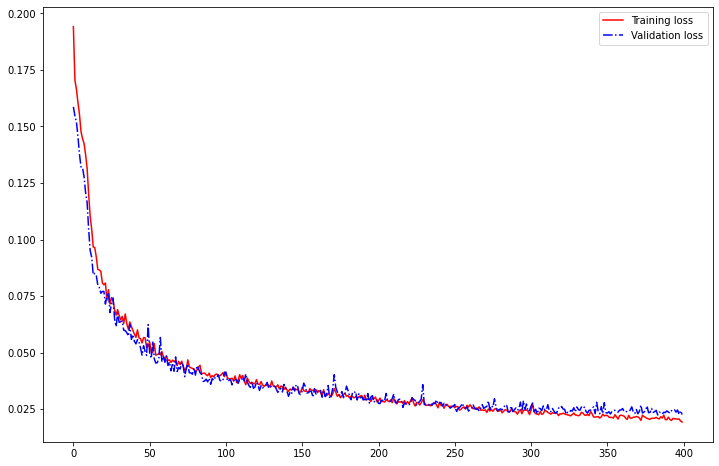

In [14]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(loss))
plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b-.', label='Validation loss')
plt.legend()

plt.show()

In [15]:
y_pred = model.predict(x_val)

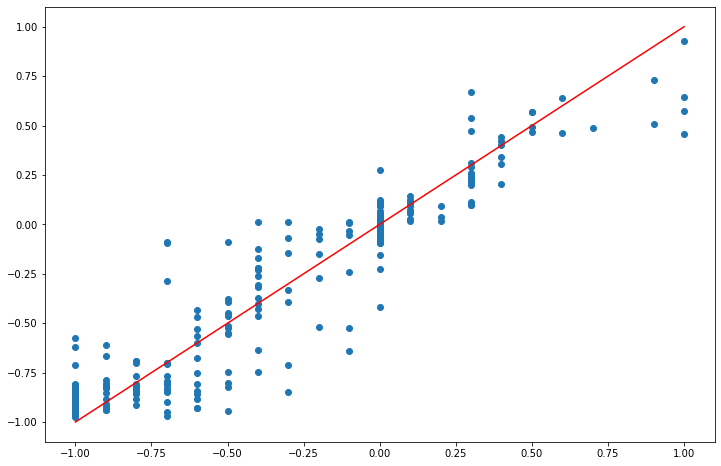

In [16]:
# Stearing
x = np.array([-1,1])
plt.figure(figsize=(12,8))
plt.plot(x,x, 'r')
plt.scatter(y_val[:, 0], y_pred[:, 0])
plt.show()

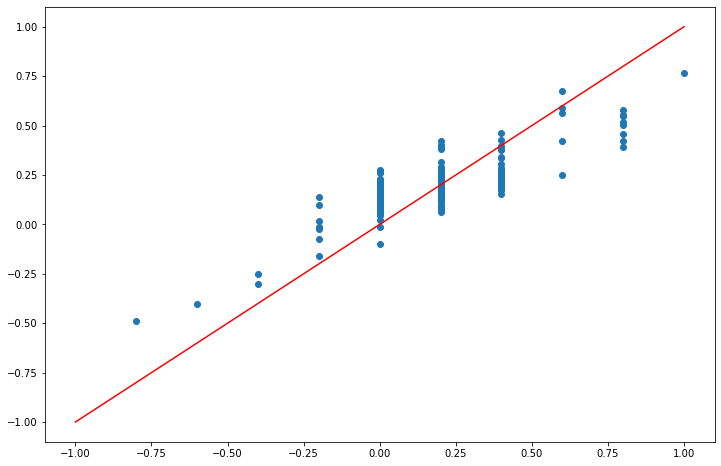

In [17]:
# Speed
x = np.array([-1,1])
plt.figure(figsize=(12,8))
plt.plot(x,x, 'r')
plt.scatter(y_val[:, 1], y_pred[:, 1])
plt.show()

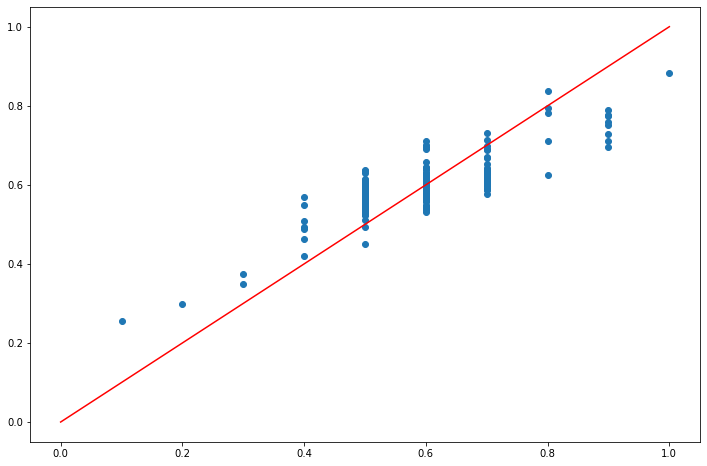

In [18]:
# Speed original
x = np.array([0,1])
plt.figure(figsize=(12,8))
plt.plot(x,x, 'r')
plt.scatter(revert_mapping(y_val[:, 1]), revert_mapping(y_pred[:, 1]))
plt.show()

In [19]:
model.save("self-drive-conv-model-20200626")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: self-drive-conv-model-20200626/assets
